Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
import re
from string import punctuation

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/LexusShabunya/projects/main/DATA/tweets.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Задание 1

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [4]:
data.isna().mean()
# видно что пропуски есть, причём в призаке местоположение - их достаточно весомая часть

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [5]:
data.fillna('', inplace=True) # заполняем пропуски пустой строкой

data.isna().any()

id          False
keyword     False
location    False
text        False
target      False
dtype: bool

Разделим данные на обучающую и тестовую выборку

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 2 
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


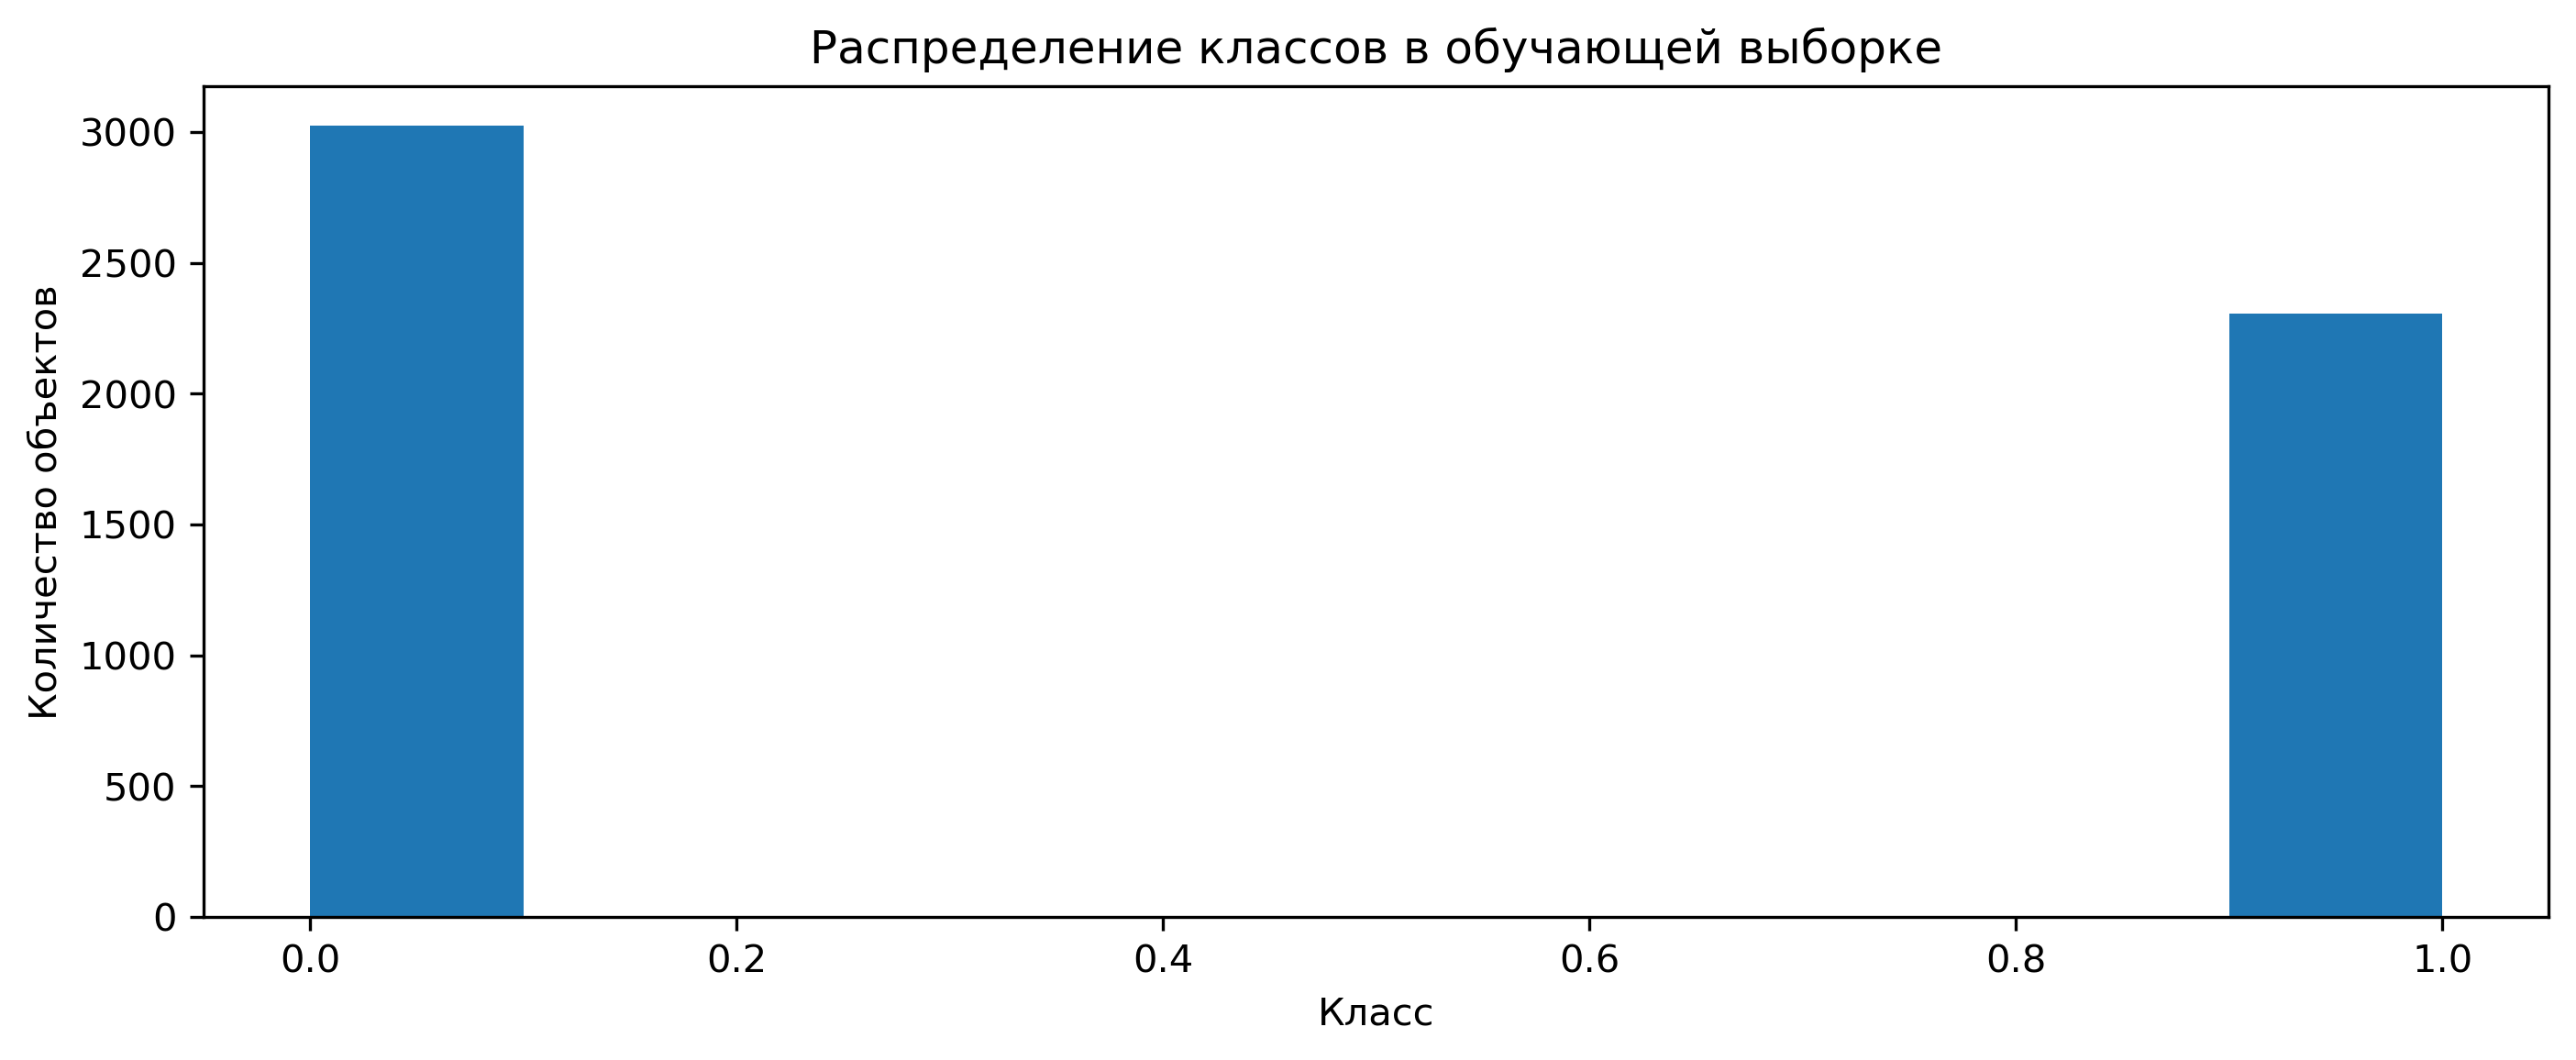

In [7]:
y_train = train.target

fig, ax = plt.subplots(1, 1, dpi=300, figsize=(11, 4))

ax.hist(y_train)

ax.set_title('Распределение классов в обучающей выборке')
ax.set_xlabel('Класс')
ax.set_ylabel('Количество объектов')

plt.show()

# распределение классов не сильно разное 

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [8]:
popular_keywords = train.keyword.value_counts().nlargest(11)
popular_keywords = set(popular_keywords.index)
popular_keywords

{'',
 'damage',
 'deluge',
 'derail',
 'fatalities',
 'fatality',
 'fear',
 'refugees',
 'siren',
 'tsunami',
 'wreckage'}

In [9]:
def is_common_word(word):
    if word in popular_keywords:
        return True
    return False

z = train.keyword.apply(is_common_word) # все наблюдения с наиболее частыми значениями keyword
z

1186    False
4071    False
5461    False
5787    False
7445    False
        ...  
5226    False
5390    False
860     False
7603     True
7270    False
Name: keyword, Length: 5329, dtype: bool

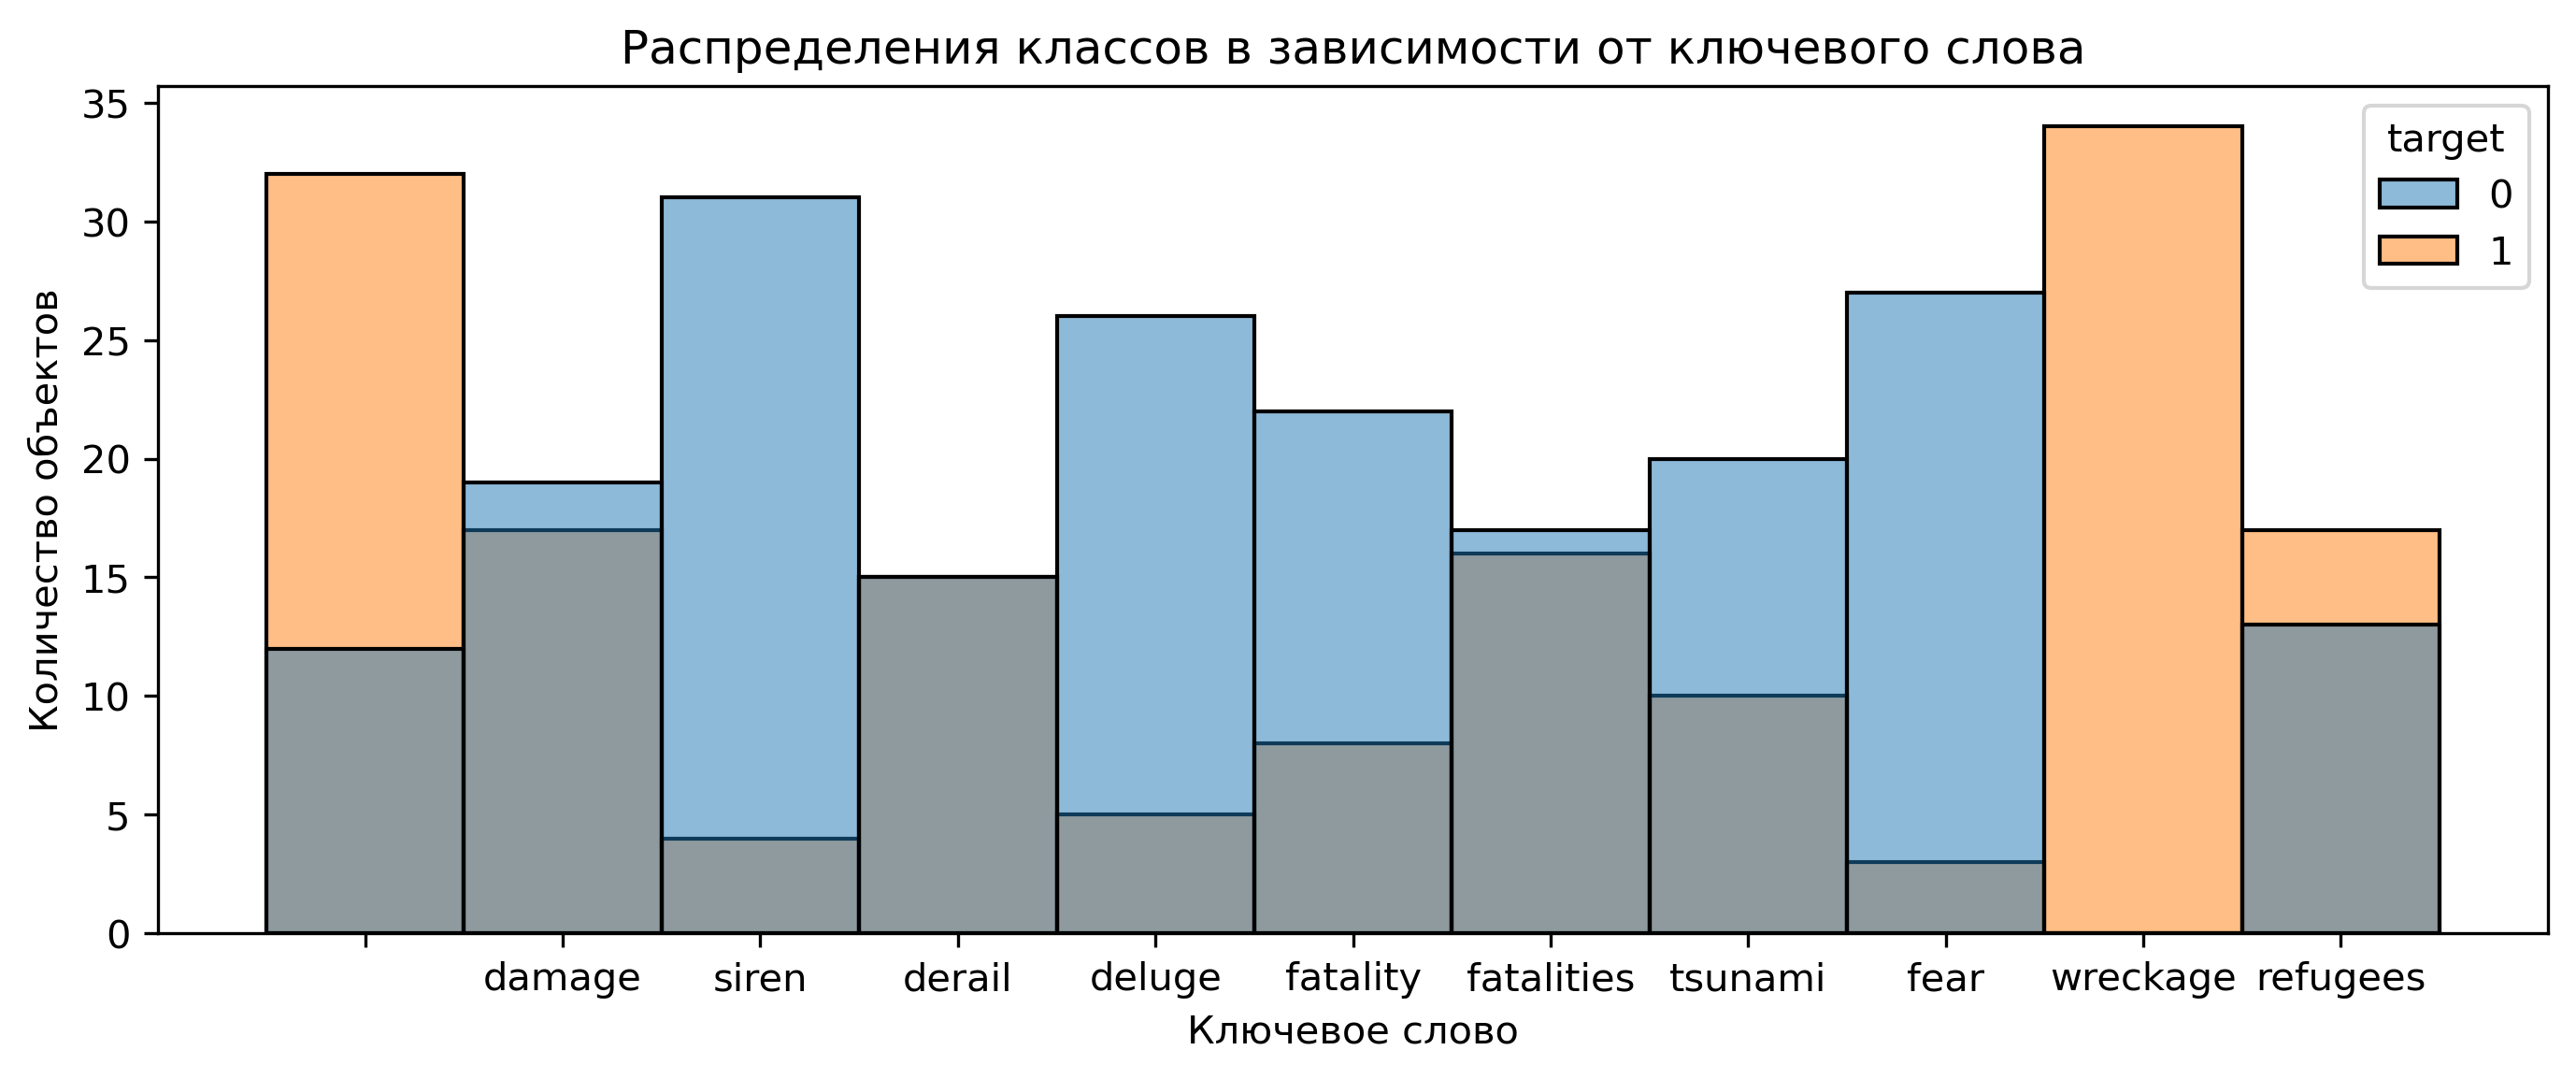

In [10]:
fig, ax = plt.subplots(1, 1, dpi=300, figsize=(11, 4))

sns.histplot(data=train[z], x='keyword', hue='target', ax=ax)

ax.set_title('Распределения классов в зависимости от ключевого слова')
ax.set_xlabel('Ключевое слово')
ax.set_ylabel('Количество объектов')

plt.show()


**Выводы**: в случае реальной катасрофы в твите чаще всего либо нет ключевого слова, либо это слово - обломки, а когда в твите ключевые слова такие как: сирена, потоп или страх, чаще такие твиты не о реальной катастрофе

## Задание 3

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [11]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [12]:
train.drop(columns='id', inplace=True) # удаляем стобец id

In [13]:
train.text = train.keyword + ' ' + train.location + ' ' + train.text # конкатенируем признаки
train_new = train.drop(columns=['keyword', 'location']) # выкидываем ненужные после конкатенации

In [14]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer()

X_train = cnt_vec.fit_transform(train_new.text)
X_train

# получилась матрица огромного размера 5329 строк и 18455 столбцов

<5329x18455 sparse matrix of type '<class 'numpy.int64'>'
	with 86671 stored elements in Compressed Sparse Row format>

## Задание 5

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [16]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any([symbol.isdigit() for symbol in s]) # если хотя бы одно значение True, то вернёт True

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    PUNCTUATION = set(punctuation) # множество знаков пунктуации, для скорости
    
    return any([symbol in PUNCTUATION for symbol in s]) 

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary): # простейший алгоритм подсчёта слов
    with_digit = 0
    with_punctuation = 0
    hashtags = 0
    mentions = 0
    
    for word, count in vocabulary.items():
        if contains_digit(word):
            with_digit += 1
        
        if contains_punctuation(word):
            with_punctuation += 1
        
        if is_hashtag(word):
            hashtags += 1
        
        if is_mention(word):
            mentions += 1
        
    print('With digit:      ', with_digit
          )
    print('With punctuation:', with_punctuation
          )
    print('Hashtags:        ', hashtags
          )
    print('Mentions:        ', mentions
          )




In [17]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [18]:
investigate_vocabulary(cnt_vec.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [19]:
!pip install nltk

In [20]:
import nltk

In [21]:
tokenizer = nltk.tokenize.TweetTokenizer() # создаём экземпляр токенайзера
cnt_vec_tweet = CountVectorizer(tokenizer=tokenizer.tokenize) # создаём экзаэмпляр векторайзера с нашим токенизатором

In [22]:
X_train = cnt_vec_tweet.fit_transform(train_new.text)
X_train

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [23]:
investigate_vocabulary(cnt_vec_tweet.vocabulary_
                       )

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** Получается гораздо более большая матрица, а также сильно возросло количество токенов со знаками пунктуации, хэштегами и упоминаниями.

## Задание 7 

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [24]:
nltk.download('stopwords', quiet=True) # загрузка стопслов

True

In [25]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return not bool(re.search(r'[^a-z]', s)) # находит всё кроме латинских букв, поэтому not

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    PUNCTUATION = set(punctuation)
    BRACKETS = set('()')
    
    only_punct = all([symbol in PUNCTUATION for symbol in s])
    had_bracket = any([symbol in BRACKETS for symbol in s])
    
    return only_punct and had_bracket

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    STOP_WORDS = set(nltk.corpus.stopwords.words('english')) # множество стопслов, для скорости
    
    stemmer = nltk.stem.snowball.SnowballStemmer('english') # создаём экземпляр стеммера
    
    s = s.lower() # передим строку в нижний регистр
    
    tokens = nltk.tokenize.TweetTokenizer().tokenize(s) # токенизируем
    
    # создаём функцию фильрации по условиям
    fliter_func = lambda s: (is_hashtag(s) or is_emoji(s) or contains_only_latin_letters(s)) and s not in STOP_WORDS
    
    filtered_tokens = filter(fliter_func, tokens) # применяем фильтрацию
    
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens] # делаем стемминг
    
    return stemmed_tokens
    
    
    
  

In [26]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [27]:
train_new.head(10).text.apply(custom_tokenizer)

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                  [destroy, (, ask, ), destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: text, dtype: object

## Задание 8 

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [28]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer
                             )

X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)
y_train = train.target
y_test = test.target

2. Обучите LogisticRegression на полученных признаках.

In [29]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)

3. Посчитайте метрику f1-score на тестовых данных.

In [30]:
from sklearn.metrics import f1_score

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')

Matrix size: (5329, 10482)
F1 score: 0.7026364193746167


## Задание 9

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer1 = TfidfVectorizer(tokenizer=custom_tokenizer)

X_train = tfidf_vectorizer1.fit_transform(train.text)
X_test = tfidf_vectorizer1.transform(test.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')


Matrix size: (5329, 10482)
F1 score: 0.739564961787184


1. **Ответ:** видно, что качество выросло при тех же размерах матрицы, что конечно же не может быть плохо

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [32]:
tfidf_vectorizer2 = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)

X_train = tfidf_vectorizer2.fit_transform(train.text)
X_test = tfidf_vectorizer2.transform(test.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')

Matrix size: (5329, 10482)
F1 score: 0.739564961787184


2. **Ответ:** ничего совсем не поменялось, скорее всего потому что мы итак выкинули "не несущие информации" стоп слова

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [33]:
tfidf_vectorizer3 = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=0.001, max_df=0.9)

X_train = tfidf_vectorizer3.fit_transform(train.text)
X_test = tfidf_vectorizer3.transform(test.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')

Matrix size: (5329, 1741)
F1 score: 0.7365994236311239


3. **Ответ:** размерность матрицы значительно снизилась при довольно малых изменениях качества, я бы сказал что это тоже успех

## Задание 10

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [34]:
from sklearn.feature_extraction.text import HashingVectorizer

hashing_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)

X_train = hashing_vectorizer.fit_transform(train.text)
X_test = hashing_vectorizer.transform(test.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')

/Users/alex/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Matrix size: (5329, 5000)
F1 score: 0.714622641509434


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самый высокий результат дал метод с Tf-Idf векторизацией

## Задание 11 

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [35]:
# немного изменим кастомный векторайзер

def my_tokenizer(s: str) -> List[str]:
    STOP_WORDS = set(nltk.corpus.stopwords.words('english')) # множество стопслов, для скорости
    
    stemmer = nltk.stem.snowball.SnowballStemmer('english') # создаём экземпляр стеммера
    
    s = s.lower() # передим строку в нижний регистр
    
    tokens = nltk.tokenize.TweetTokenizer().tokenize(s) # токенизируем
    
    # создаём функцию фильрации по условиям
    fliter_func = lambda s: is_hashtag(s) or contains_only_latin_letters(s)
    
    filtered_tokens = filter(fliter_func, tokens) # применяем фильтрацию
    
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens] # делаем стемминг
    
    return stemmed_tokens

In [36]:
# попробуем докрутить метод с Tf-Idf векторизацией, изменяя max_df векторайзера

tfidf_vectorizer4 = TfidfVectorizer(tokenizer=my_tokenizer, max_df=0.1)

X_train = tfidf_vectorizer4.fit_transform(train.text)
X_test = tfidf_vectorizer4.transform(test.text)

logreg = LogisticRegression().fit(X_train, y_train)

test_score = f1_score(y_test, logreg.predict(X_test))

print(f'Matrix size: {X_train.shape}')
print(f'F1 score: {test_score}')

#профит!

Matrix size: (5329, 10576)
F1 score: 0.7501456027955737
